# Pool-based sampling
## Overview
We apply an `ActiveLearner` (scikit-learn KNN classifier) onto the iris dataset using pool-based sampling.

**Pool-based sampling** is a popular technique in **active learning** that aims to efficiently select unlabeled data points to improve a model while minimizing the number of annotations required.

---

## What is Pool-Based Sampling?

- **Definition**:  
  In this approach:
  1. A small labeled dataset ($L$) is used to initially train the model.
  2. A large unlabeled dataset ($U$), called the "pool," is available, from which examples are selectively chosen for annotation by a human expert.

  The model uses a specific criterion to identify the most informative examples from the pool to improve its performance.

---

## How Does It Work?

1. **Initialization**:
   - The model is trained on the labeled dataset ($L$).

2. **Predictions on the Pool**:
   - The model evaluates all the examples in the unlabeled pool ($U$) and estimates their informativeness or uncertainty.

3. **Selection Criterion**:
   - The most informative examples are selected from the pool based on a specific criterion (explained below).

4. **Human Annotation**:
   - The selected examples are sent to a human expert for labeling.

5. **Update**:
   - The newly labeled data is added to the labeled dataset ($L$), and those examples are removed from the pool ($U$).
   - The model is retrained with the expanded labeled dataset.

6. **Repeat**:
   - This cycle continues until a stopping criterion is met (e.g., a maximum number of queries or a desired level of accuracy).

---

## Common Selection Criteria

1. **Uncertainty Sampling**:
   - Selects examples where the model is least confident about its predictions.
   - Examples:
     - **Margin Sampling**: Selects instances with the smallest difference between the probabilities of the two most likely classes.
     - **Entropy Sampling**: Selects instances with the highest entropy in their predicted class probabilities.

     Entropy formula for an instance $x$:
     $$
     H(x) = - \sum_{i=1}^C P(y_i|x) \log P(y_i|x)
     $$

2. **Diversity Sampling**:
   - Selects diverse examples to ensure coverage of various regions in the feature space and avoid redundancy.

3. **Expected Model Change**:
   - Chooses examples that are expected to cause the largest change in the model's parameters after being labeled.

4. **Query-by-Committee (QBC)**:
   - Trains multiple models (a committee) and selects instances where the models disagree the most.

---

## Advantages of Pool-Based Sampling

1. **Efficiency**:
   - Reduces the number of annotations needed by focusing on the most informative examples.

2. **Customizability**:
   - Allows tailoring of the selection criterion based on the specific problem.

3. **Flexibility**:
   - Can be applied to a wide range of models and data types.

---

## Challenges

1. **Annotation Costs**:
   - Still relies on human experts for labeling selected examples.

2. **Risk of Bias**:
   - Poorly designed selection criteria can lead to biased or overfitted models.

3. **Frequent Retraining**:
   - The model needs to be retrained often as new labeled data becomes available, which can be computationally expensive.

---

## Practical Example

**Problem**: Classify images as "cat" or "dog."

- \(L\): 100 labeled images (e.g., "cat" or "dog").
- \(U\): 1000 unlabeled images.

### Process:
1. Train a model using $L$.
2. Predict labels for the 1000 images in $U$.
3. Use entropy sampling to select 10 images with the highest uncertainty.
4. Send these 10 images to a human expert for labeling.
5. Add the newly labeled images to $L$, remove them from $U$, and retrain the model.
6. Repeat until a desired level of performance is achieved.




In [1]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

## Dataset
We load the iris dataset.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

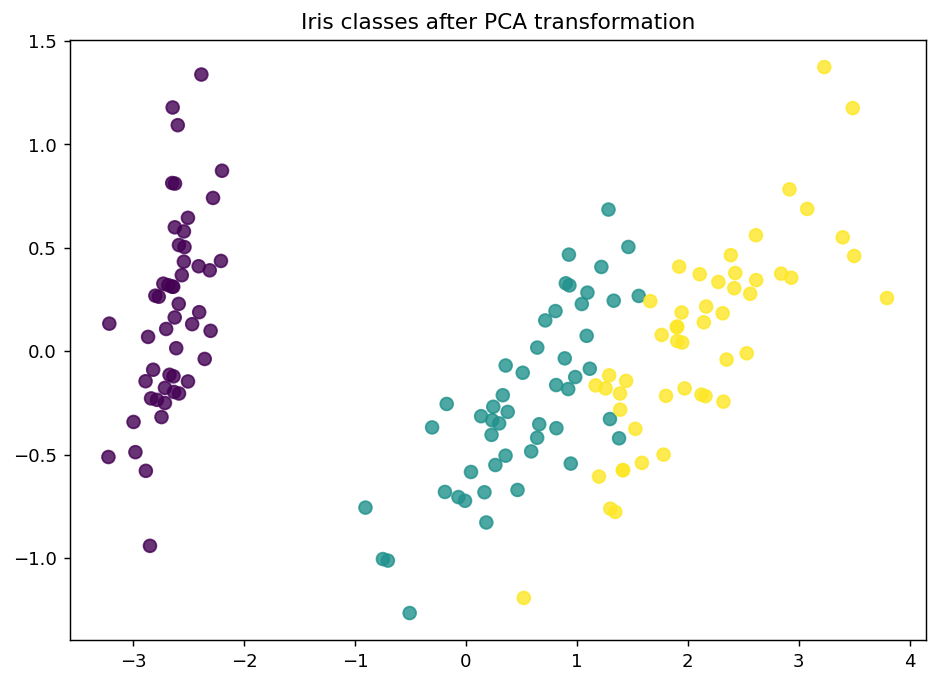

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our iris dataset into a training set $L$ and $U$. We first specify our training set $L$ consisting of 3 random examples. The remaining examples go to our “unlabeled” pool $U$.

In [5]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

For the classification, we are going to use a simple k-nearest neighbors classifier. In this step, we are also going to initialize the `ActiveLearner`.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [7]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

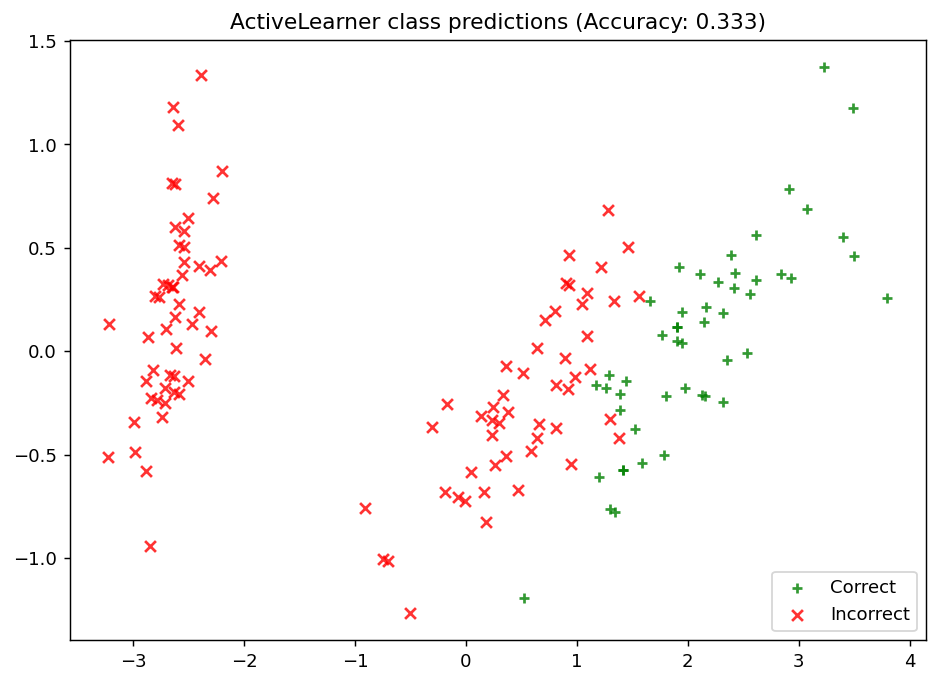

In [8]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

## Update our model by pool-based sampling our unlabeled pool $U$.
As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn’t seen before. Using uncertainty sampling, our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures — see the documentation for more on specific classification uncertainty measures. With each requested query, we remove that record from our pool $U$ and record our model’s accuracy on the raw dataset.

In [9]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


## Evaluate our model's performance
Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

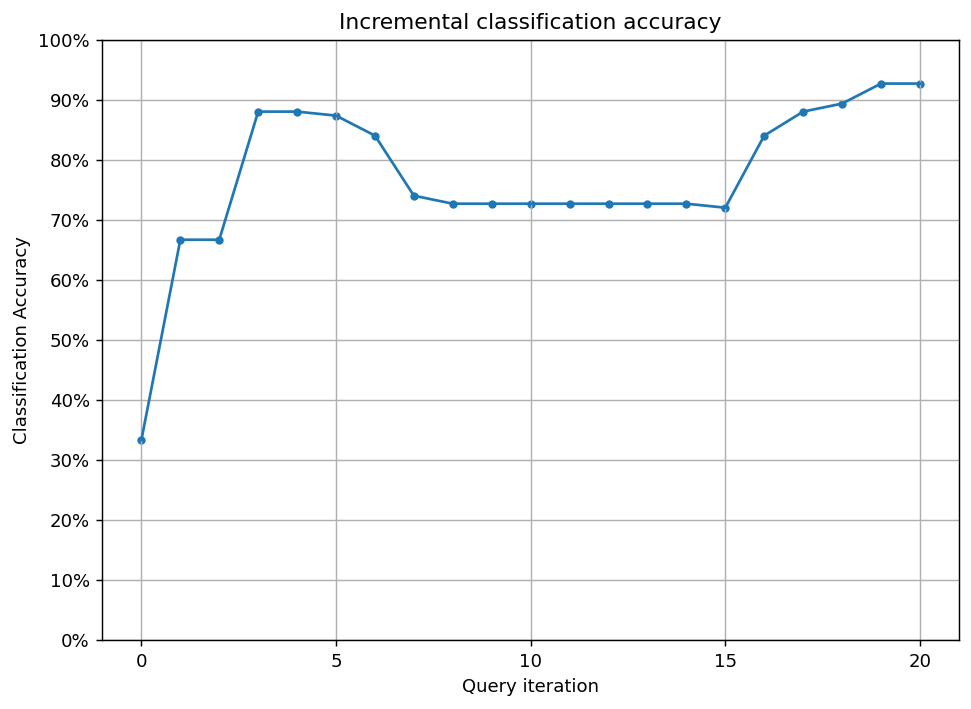

In [10]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

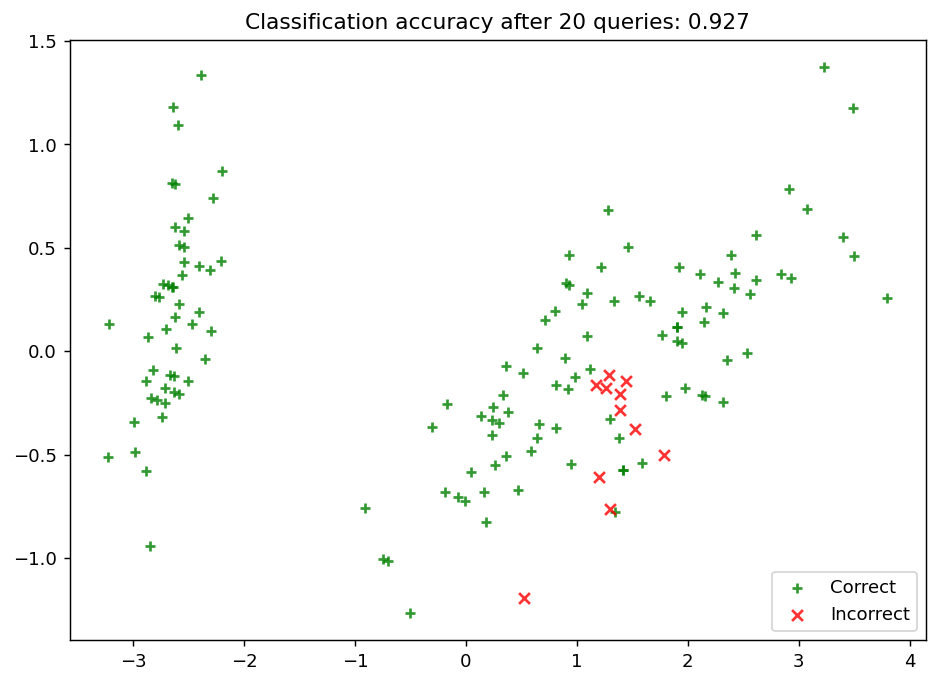

In [11]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()